In [134]:
import open3d
from moseq2_detectron_extract.io.session import Session, Stream
from moseq2_detectron_extract.proc.proc import prep_raw_frames, clean_frames, get_frame_features, colorize_video
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import copy
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

import cv2



In [53]:
#session = Session(r"H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Abraira_Lab\Spinal_Cord_Injury-C57BL6\11_animal_subset\session_20200814144734.tar.gz")
session = Session(r"H:\Tischfield_Lab_ISI\MoSeq\moseq2\Raw_Data\Dulin_Lab\DREADDs Cohort- Ashley Tucker\Week 9 Post Transplantation Post CNO\session_20220819105327.tar.gz")
first_frame, bground_im, roi, true_depth = session.find_roi()

In [54]:
frame_idx, raw_frame = next(session.index([0]))
preped_frame = prep_raw_frames(raw_frame,
                               bground_im=session.bground_im,
                               roi=session.roi,
                               vmin=0,
                               vmax=100)
#xyz = np.zeros((raw_frame.shape[1] * raw_frame.shape[2], 3))
xyz = []
for i in range(preped_frame.shape[1]):
    for j in range(preped_frame.shape[2]):
        xyz.append([i, j, preped_frame[0, i, j]])
xyz = np.array(xyz)

pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(xyz)
pcd

PointCloud with 62244 points.

In [250]:
open3d.visualization.draw_geometries([pcd])

In [251]:
pcd.estimate_normals(search_param=open3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16), fast_normal_computation=True)
plane_model, inliers = pcd.segment_plane(distance_threshold=3, ransac_n=10, num_iterations=1000)
inlier_cloud = pcd.select_by_index(inliers)
outlier_cloud = pcd.select_by_index(inliers, invert=True)
inlier_cloud.paint_uniform_color([1, 0, 0])
outlier_cloud.paint_uniform_color([0.6, 0.6, 0.6])
open3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [252]:
labels = np.array(outlier_cloud.cluster_dbscan(eps=5, min_points=10))
print(labels)
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
outlier_cloud.colors = open3d.utility.Vector3dVector(colors[:, :3])
open3d.visualization.draw_geometries([outlier_cloud])

[ 0  0  0 ... 29 29 29]


In [253]:
largest_label = stats.mode(labels[labels >= 0], axis=None, keepdims=False).mode
print(largest_label)
seg_points = outlier_cloud.select_by_index((labels == largest_label).nonzero()[0])
open3d.visualization.draw_geometries([seg_points])

0


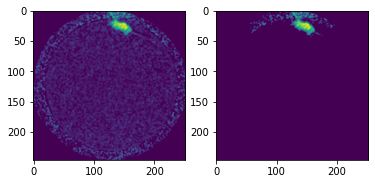

In [254]:
clean_image = np.zeros_like(preped_frame)
for point in seg_points.points:
    clean_image[0, int(point[0]), int(point[1])] = point[2]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(preped_frame[0])
axs[1].imshow(clean_image[0])

In [259]:
seg_points.estimate_normals(search_param=open3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16), fast_normal_computation=True)
hull, densities =  open3d.geometry.TriangleMesh.create_from_point_cloud_poisson(seg_points, depth=14)
#vertices_to_remove = densities < np.quantile(densities, 0.3)
#hull.remove_vertices_by_mask(vertices_to_remove)
hull.compute_vertex_normals()
open3d.visualization.draw_geometries([seg_points, hull])

In [223]:
type(hull)

open3d.cpu.pybind.geometry.TriangleMesh

In [260]:
scene = open3d.t.geometry.RaycastingScene()
_ = scene.add_triangles(open3d.t.geometry.TriangleMesh.from_legacy(hull))  # we do not need the geometry ID for mesh

distances = []
for point in seg_points.points:
    distances.append(scene.compute_distance(open3d.core.Tensor([[*point]], dtype=open3d.core.Dtype.Float32)).numpy())
distances = np.array(distances)

strigent_seg_points = seg_points.select_by_index((distances > 1).nonzero()[0], invert=True)
open3d.visualization.draw_geometries([strigent_seg_points, hull])


In [261]:
triangle_clusters, cluster_n_triangles, cluster_area = (hull.cluster_connected_triangles())
triangle_clusters = np.asarray(triangle_clusters)
cluster_n_triangles = np.asarray(cluster_n_triangles)
cluster_area = np.asarray(cluster_area)

mesh_0 = copy.deepcopy(hull)
triangles_to_remove = cluster_n_triangles[triangle_clusters] < 100
mesh_0.remove_triangles_by_mask(triangles_to_remove)
open3d.visualization.draw_geometries([mesh_0, seg_points])

In [228]:
open3d.core.Tensor([[*point]], dtype=open3d.core.Dtype.Float32)

[[51.0 179.0 5.0]]
Tensor[shape={1, 3}, stride={3, 1}, Float32, CPU:0, 0x21bc8d39180]

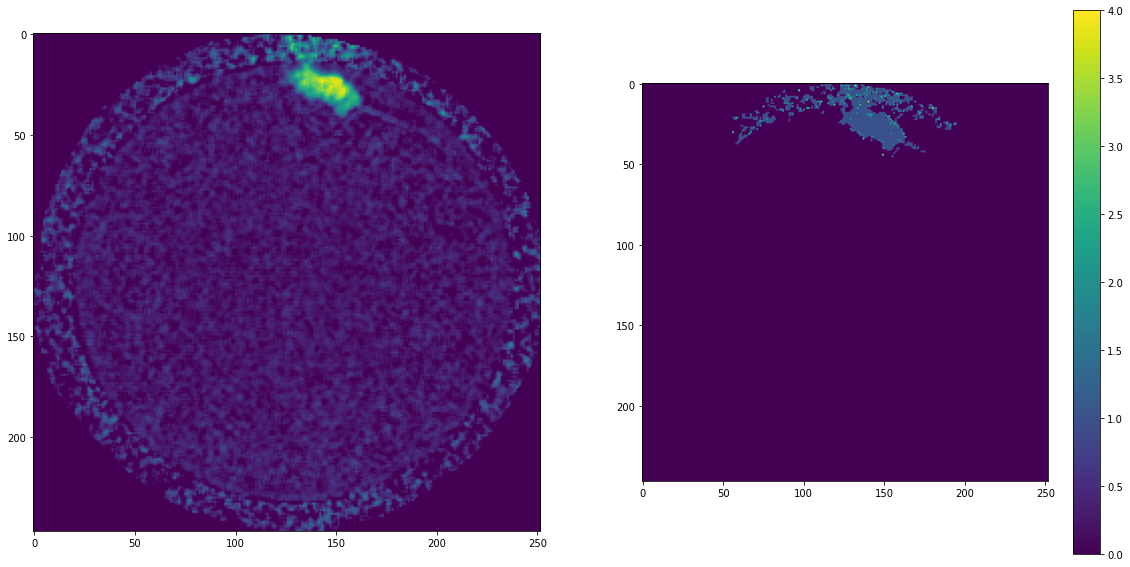

In [99]:
dists = seg_points.compute_nearest_neighbor_distance()
dist_map = np.zeros_like(preped_frame)
for i, point in enumerate(seg_points.points):
    dist_map[0, int(point[0]), int(point[1])] = dists[i]

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(preped_frame[0])
im = axs[1].imshow(dist_map[0])
fig.colorbar(im)


Text(0.5, 1.0, 'Separated objects')

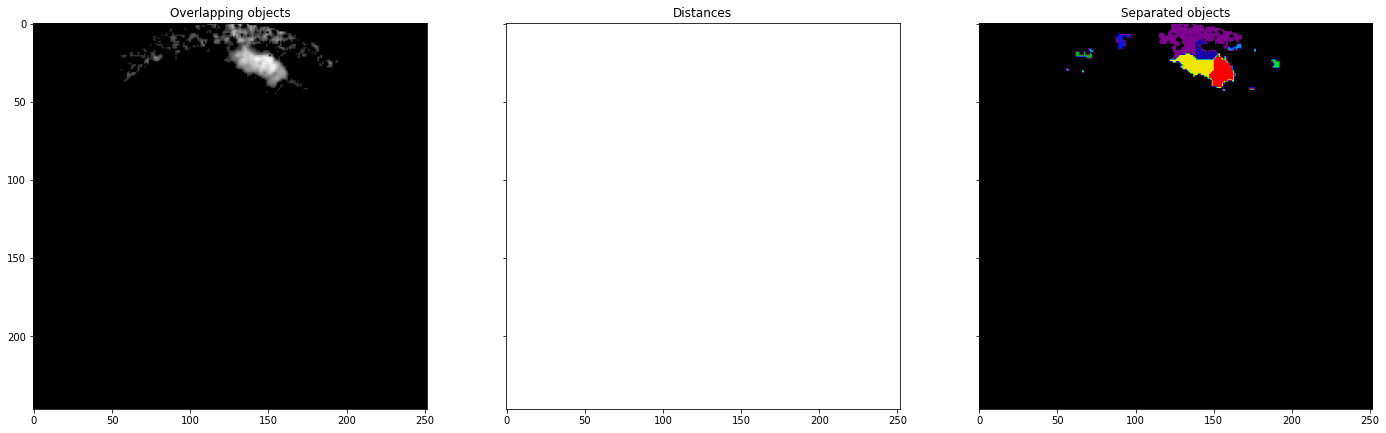

In [132]:
bin_image = clean_image[0] #np.where(clean_image[0], 1, 0)
distance = ndi.distance_transform_edt(bin_image)
coords = peak_local_max(distance, min_distance=10, footprint=np.ones((30, 30)), labels=bin_image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=bin_image)

fig, axes = plt.subplots(ncols=3, figsize=(24, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(clean_image[0], cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance.astype(float), cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

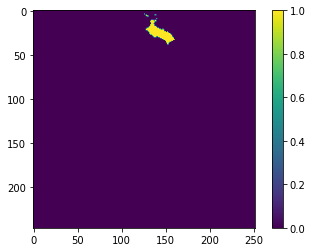

In [160]:
plt.imshow(ndi.distance_transform_edt(clean_image[0]) > 3)
plt.colorbar()

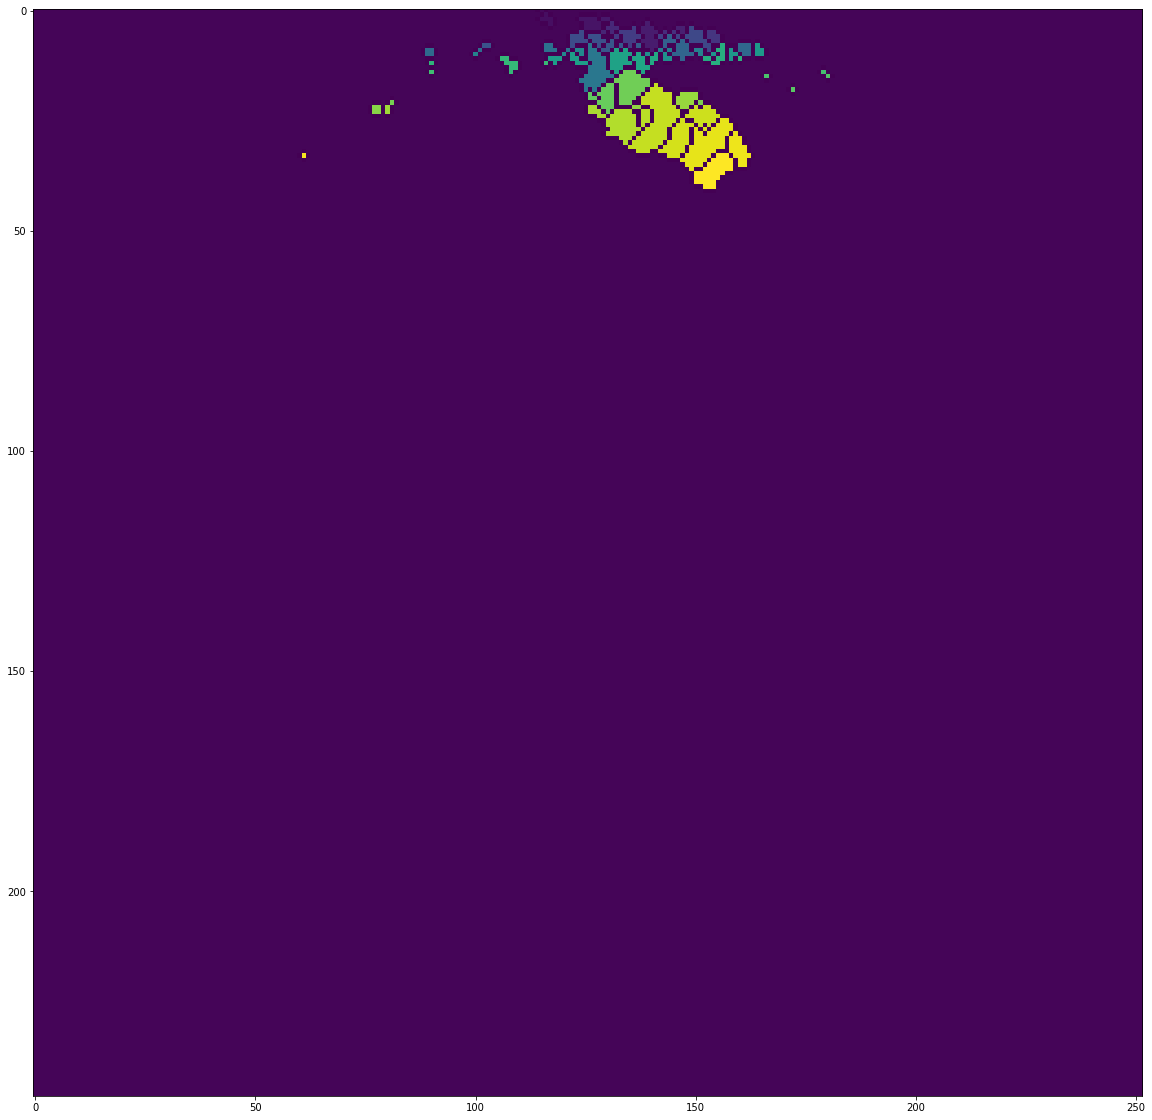

In [121]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(watershed(-clean_image[0], watershed_line=True))

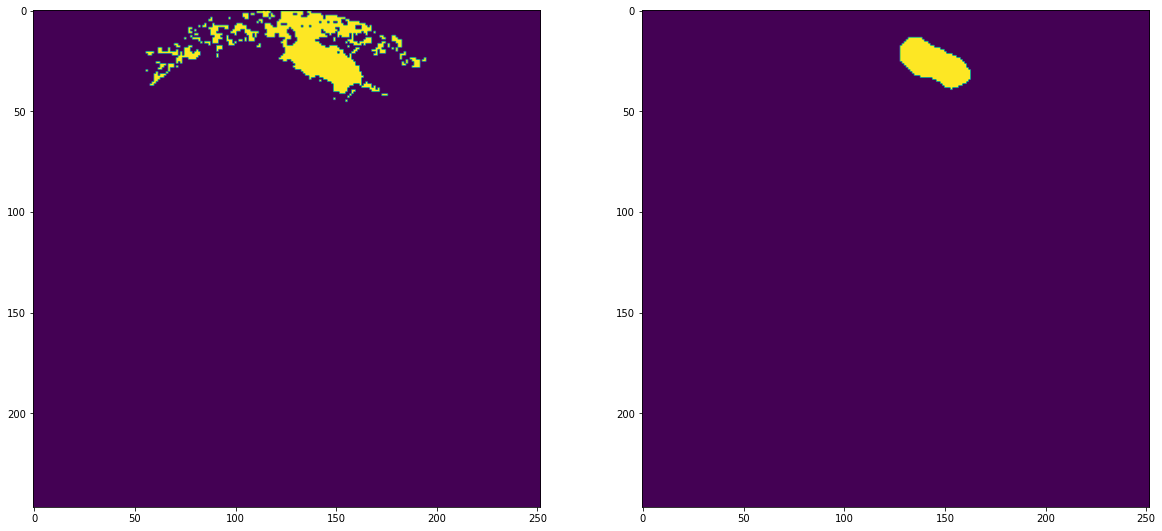

In [144]:

mask = np.where(clean_image[0], 1, 0).astype('uint8')
strel_min = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
result = cv2.morphologyEx(mask, cv2.MORPH_OPEN, strel_min)
# eroded = cv2.erode(mask, strel_min, 1)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(mask)
axs[1].imshow(result)

Computing moments: 100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


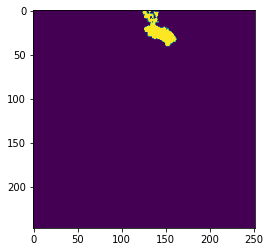

In [153]:
features, mask = get_frame_features(clean_image, use_cc=True, mask_threshold=10)
plt.imshow(mask[0])

C:\Users\thackray\AppData\Local\Temp/ipykernel_14012/1461334356.py:21: RuntimeWarning: invalid value encountered in cast
  std = cv2.sqrt(var).clip(0,255).astype(np.uint8)


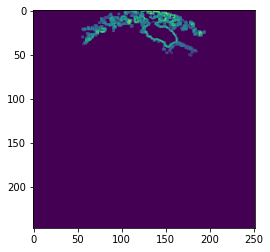

In [198]:
from skimage.morphology import rectangle
import skimage.filters as filters

def get_image_stdev(img, kernel=(3,3)):
    # compute square of image
    img_sq = cv2.multiply(img, img)

    # compute local mean in 5x5 rectangular region of each image
    # note: python will give warning about slower performance when processing 16-bit images
    region = rectangle(*kernel)
    mean_img = filters.rank.mean(img, selem=region)
    mean_img_sq = filters.rank.mean(img_sq, selem=region)

    # compute square of local mean of img
    sq_mean_img = cv2.multiply(mean_img, mean_img)

    # compute variance using float versions of images
    var = cv2.add(mean_img_sq.astype(np.float32), -sq_mean_img.astype(np.float32))

    # compute standard deviation and convert to 8-bit format
    std = cv2.sqrt(var).clip(0,255).astype(np.uint8)

    return std

plt.imshow(get_image_stdev(clean_image[0]))

(array([5.9984e+04, 8.9000e+01, 5.8100e+02, 5.8200e+02, 0.0000e+00,
        5.0200e+02, 3.3100e+02, 1.5200e+02, 2.2000e+01, 1.0000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

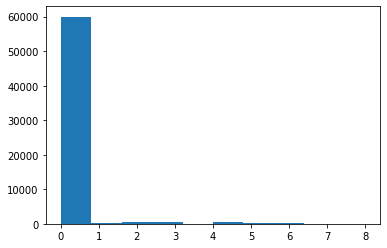

In [201]:
plt.hist(std.ravel())

(array([  506.,  1084.,   581.,     0.,    89.,     0.,     0.,     0.,
            0., 59984.]),
 array([0.11111111, 0.2       , 0.28888889, 0.37777778, 0.46666667,
        0.55555556, 0.64444444, 0.73333333, 0.82222222, 0.91111111,
        1.        ]),
 <BarContainer object of 10 artists>)

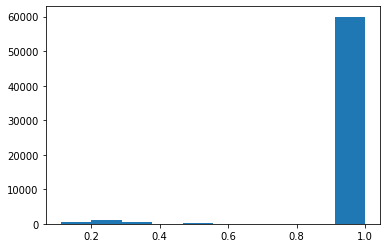

In [248]:
plt.hist((1 / (std + 1)).ravel())

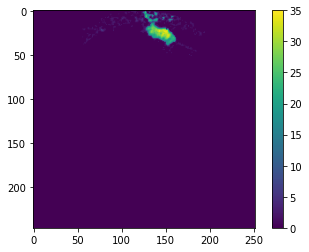

In [249]:
plt.imshow((1 / (std + 1)) * clean_image[0])
plt.colorbar()

In [197]:
get_image_stdev(clean_image[0]).shape

C:\Users\thackray\AppData\Local\Temp/ipykernel_14012/2955082718.py:21: RuntimeWarning: invalid value encountered in cast
  std = cv2.sqrt(var).clip(0,255).astype(np.uint8)


AttributeError: 'NoneType' object has no attribute 'shape'

In [210]:
ret, thresh = cv2.threshold(clean_image[0], 1, 100, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, 2, 1)
cnt = contours[0]
convexHull = cv2.convexHull(cnt, returnPoints=False)
defects = cv2.convexityDefects(cnt, convexHull)

print(defects)

img = clean_image[0].copy()
for i in range(defects.shape[0]):
    s,e,f,d = defects[i,0]
    start = tuple(cnt[s][0])
    end = tuple(cnt[e][0])
    far = tuple(cnt[f][0])
    cv2.line(img,start,end,[0,255,0],2)
    cv2.circle(img,far,5,[0,0,255],-1)



plt.imshow(img)

None


AttributeError: 'NoneType' object has no attribute 'shape'